In [7]:
pip install pandas numpy scikit-learn seaborn matplotlib openpyxl


In [9]:
# Step 1: Importing  Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import joblib

# step 2 Load both sheets
df1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [10]:
df1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [11]:
df2.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [13]:
# Step 3: Preprocessing  Data
for df in [df1, df2]:
    df.columns = df.columns.str.strip()
    df.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)
    df.dropna(subset=['CustomerID'], inplace=True)
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['TotalPrice'] = df['Quantity'] * df['Price']
    df = df[df['Quantity'] > 0]


In [14]:

# Step 4: Feature Set from 2009-2010
df_early = df1[df1['Quantity'] > 0]
df_early = df_early[~df_early['Invoice'].astype(str).str.startswith('C')]
snapshot_date = df_early['InvoiceDate'].max() + pd.Timedelta(days=1)

features = df_early.groupby('CustomerID').agg({
    'Invoice': 'nunique',
    'Quantity': 'sum',
    'Price': 'mean',
    'InvoiceDate': [
        lambda x: (snapshot_date - x.max()).days,
        lambda x: (x.max() - x.min()).days
    ]
}).reset_index()

features.columns = ['CustomerID', 'invoice_count', 'total_quantity', 'avg_price', 'recency_days', 'lifespan_days']


In [15]:

# Step 5: Label CLV from 2010-2011
df_future = df2[df2['Quantity'] > 0]
df_future = df_future[~df_future['Invoice'].astype(str).str.startswith('C')]

labels = df_future.groupby('CustomerID').agg({
    'TotalPrice': 'sum'
}).reset_index().rename(columns={'TotalPrice': 'future_clv'})


In [16]:


# Step 6: Merge Features and Labels
final_df = pd.merge(features, labels, on='CustomerID', how='inner')



/tmp/ipython-input-19-2999092164.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_avg = final_df.groupby('clv_segment')['future_clv'].mean().reindex(["Low", "Medium", "High", "Very High"])
/tmp/ipython-input-19-2999092164.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_avg.index, y=segment_avg.values, ax=axes[1], palette="coolwarm")


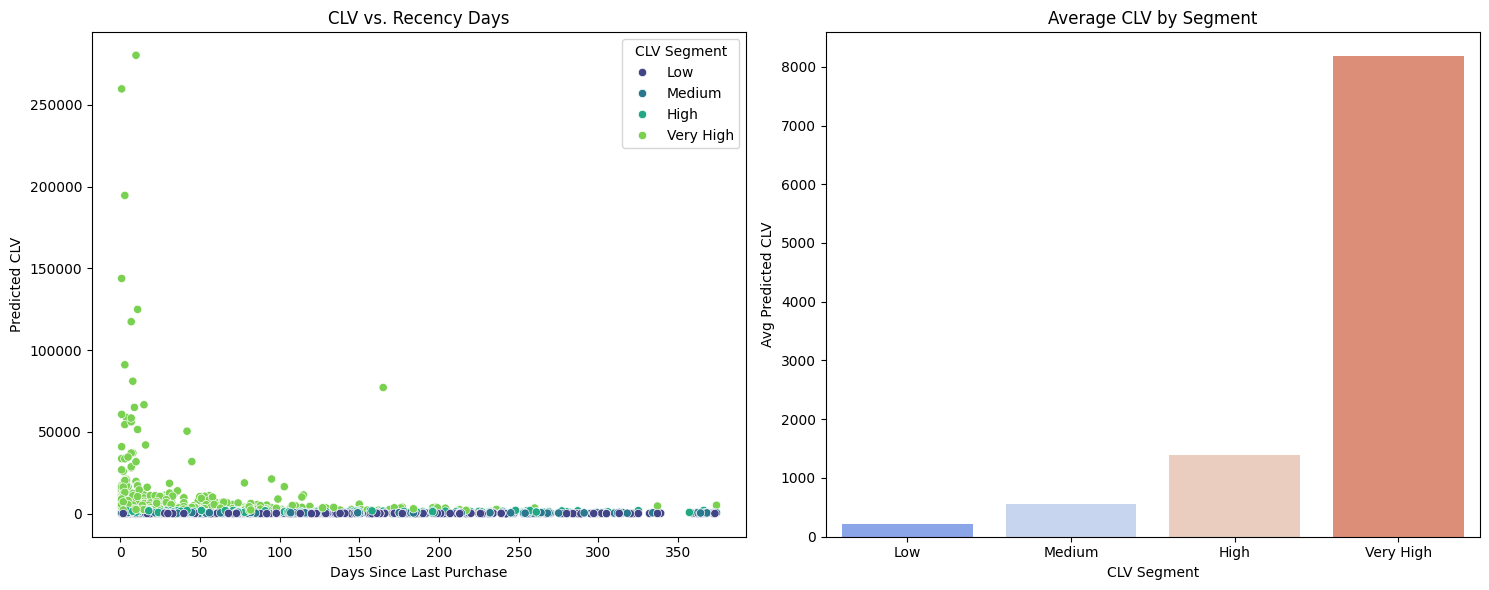

In [19]:

# Step 7: Exploratory Data Analysis (EDA)
final_df['clv_segment'] = pd.qcut(final_df['future_clv'], q=4, labels=["Low", "Medium", "High", "Very High"])
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. CLV vs. Recency Days
sns.scatterplot(
    x=final_df['recency_days'],
    y=final_df['future_clv'],
    hue=final_df['clv_segment'],
    palette='viridis',
    ax=axes[0]
)
axes[0].set_title("CLV vs. Recency Days")
axes[0].set_xlabel("Days Since Last Purchase")
axes[0].set_ylabel("Predicted CLV")
axes[0].legend(title="CLV Segment")

# 2. Average CLV by Segment
segment_avg = final_df.groupby('clv_segment')['future_clv'].mean().reindex(["Low", "Medium", "High", "Very High"])
sns.barplot(x=segment_avg.index, y=segment_avg.values, ax=axes[1], palette="coolwarm")
axes[1].set_title("Average CLV by Segment")
axes[1].set_xlabel("CLV Segment")
axes[1].set_ylabel("Avg Predicted CLV")

plt.tight_layout()
plt.show()


In [20]:

# Step 8: Train-Test Split
X = final_df[['invoice_count', 'total_quantity', 'avg_price', 'recency_days', 'lifespan_days']]
y = final_df['future_clv']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [21]:

# Step 9: Training  Models and choosing best one
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Linear Regression': LinearRegression()
}

best_model = None
best_score = -np.inf

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)

    print(f"{name} - R2: {score:.4f}, RMSE: {rmse:.2f}")

    if score > best_score:
        best_score = score
        best_model = model



Random Forest - R2: 0.6110, RMSE: 3213.41
Linear Regression - R2: 0.6895, RMSE: 2871.11


In [22]:
#step10 saving and downloading model and scaler
import joblib
import os

joblib.dump(best_model, 'clv_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

from google.colab import files
files.download('clv_model.pkl')
files.download('scaler.pkl')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>